In [1]:
import io
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Conv2D, MaxPool2D, Flatten

from urllib.request import urlretrieve
from zipfile import ZipFile
from PIL import Image

In [2]:
seed = 0

In [3]:
urlretrieve('https://raw.githubusercontent.com/prat-man/CSE-575-Statistical-Machine-Learning/main/data/spectrogram.zip', 'spectrogram.zip')

('spectrogram.zip', <http.client.HTTPMessage at 0x7fdec04e4c70>)

In [4]:
X = []
y = []

with ZipFile('spectrogram.zip', 'r') as zip:
    for name in zip.namelist():
        genre = name.split('/')[0]
        file_name = name.split('/')[1]
        
        image_data = zip.read(name)
        image = Image.open(io.BytesIO(image_data))
        # np_image = np.array(image)[35:253, 54:390, :3]
        np_image = np.array(image)[:, :, :3]
        
        X.append(np_image)
        y.append(genre)

X = np.array(X)
y = np.array(y, ndmin=2).T

In [5]:
encoder = OneHotEncoder(sparse_output=False)
y = encoder.fit_transform(y)
labels = encoder.categories_[0]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6, stratify=y, random_state=seed)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, train_size=0.5, stratify=y_test, random_state=seed)

In [7]:
model_layers = [
    Input(X_train.shape[1:4]),
    
    Conv2D(64, (3, 3)),
    MaxPool2D(pool_size=(2, 2,)),

    Conv2D(64, (3, 3)),
    MaxPool2D(pool_size=(2, 2)),

    Flatten(),

    Dense(64),

    Dense(10, activation='softmax')
]

model = Sequential(model_layers)

In [8]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [9]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 286, 430, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 143, 215, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 141, 213, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 70, 106, 64)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 474880)            0         
                                                                 
 dense (Dense)               (None, 64)                3

In [10]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

Epoch 1/10
19/19 [==============================] - 15s 336ms/step - loss: 16020.8271 - accuracy: 0.1133 - val_loss: 11494.5322 - val_accuracy: 0.1650
Epoch 2/10
19/19 [==============================] - 3s 162ms/step - loss: 4442.0918 - accuracy: 0.2383 - val_loss: 3165.8337 - val_accuracy: 0.3300
Epoch 3/10
19/19 [==============================] - 3s 161ms/step - loss: 1186.0564 - accuracy: 0.5200 - val_loss: 1464.2203 - val_accuracy: 0.3000
Epoch 4/10
19/19 [==============================] - 3s 144ms/step - loss: 335.1666 - accuracy: 0.7300 - val_loss: 1291.3699 - val_accuracy: 0.3400
Epoch 5/10
19/19 [==============================] - 3s 163ms/step - loss: 344.4004 - accuracy: 0.7383 - val_loss: 839.4835 - val_accuracy: 0.4550
Epoch 6/10
19/19 [==============================] - 3s 145ms/step - loss: 195.4129 - accuracy: 0.8217 - val_loss: 604.8683 - val_accuracy: 0.5000
Epoch 7/10
19/19 [==============================] - 3s 161ms/step - loss: 50.8476 - accuracy: 0.9167 - val_loss: 5

In [11]:
_, accuracy = model.evaluate(X_train, y_train)
print(f'Training Accuracy: {accuracy}')

19/19 [==============================] - 1s 56ms/step - loss: 25.4374 - accuracy: 0.9467
Training Accuracy: 0.9466666579246521


In [12]:
y_pred = model.predict(X_test)

y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)

7/7 [==============================] - 0s 48ms/step


In [13]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.50      0.57        20
           1       0.78      0.70      0.74        20
           2       0.67      0.10      0.17        20
           3       0.31      0.90      0.46        20
           4       0.00      0.00      0.00        20
           5       0.55      0.90      0.68        20
           6       0.90      0.90      0.90        20
           7       0.83      0.25      0.38        20
           8       0.50      0.70      0.58        20
           9       0.33      0.30      0.32        20

    accuracy                           0.53       200
   macro avg       0.55      0.53      0.48       200
weighted avg       0.55      0.53      0.48       200



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


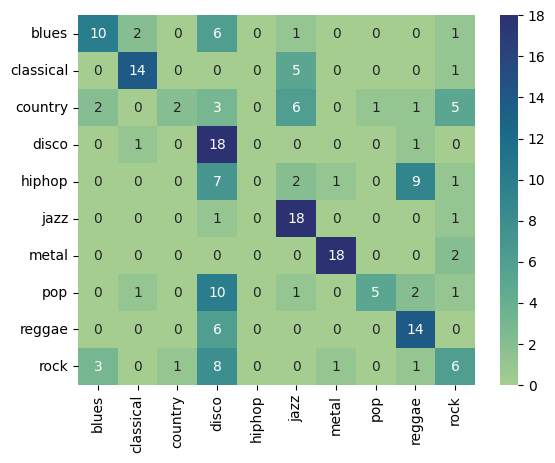

In [14]:
conf_m = confusion_matrix(y_true, y_pred)

sns.heatmap(conf_m, cmap='crest', annot=True)

plt.xticks(ticks = np.arange(0.5, 10, 1), labels=labels, rotation=90)
plt.yticks(ticks = np.arange(0.5, 10, 1), labels=labels,rotation=0)

plt.savefig('CNN_Confusion_Matrix.png', dpi=300)

In [15]:
accuracy = np.trace(conf_m) / np.sum(conf_m)
print(f'Overall test accuracy = {accuracy}')

Overall test accuracy = 0.525


In [16]:
accuracy_df = pd.DataFrame(columns=['accuracy'])

class_acc = conf_m.diagonal() / conf_m.sum(axis=1)
for i in range(len(labels)):
    accuracy_df.loc[labels[i]] = [round(class_acc[i], 2)]

accuracy_df

,accuracy
blues,0.50
classical,0.70
country,0.10
disco,0.90
hiphop,0.00
jazz,0.90
metal,0.90
pop,0.25
reggae,0.70
rock,0.30


In [17]:
model.save('CNN.h5')